In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup Wells

In [6]:
from morpheus.project.types.boundaries.WellObservation import WellRawDataItem, PumpingRate
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection, WellBoundary

boundary_collection = BoundaryCollection.new()

well_boundary_1 = WellBoundary.from_geometry(
  name=BoundaryName('well_1'),
  geometry=Point((13.921, 50.965)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      pumping_rate=PumpingRate.from_float(-1000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      pumping_rate=PumpingRate.from_float(-1000),
    ),
  ]
)

well_boundary_2 = WellBoundary.from_geometry(
  name=BoundaryName('well_2'),
  geometry=Point((13.923, 50.9655)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      pumping_rate=PumpingRate.from_float(1000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      pumping_rate=PumpingRate.from_float(1000),
    ),
  ]
)

boundary_collection.add_boundary(well_boundary_1)
boundary_collection.add_boundary(well_boundary_2)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(well_boundary_1.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_1.affected_cells.to_geojson(grid).as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.affected_cells.to_geojson(grid).as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [7]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.WelPackageMapper import \
  calculate_wel_boundary_stress_period_data

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_1,
)
print(result.to_dict())

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_2,
)
print(result.to_dict())

{0: [[0, 25, 19, -1000.0]]}
{0: [[0, 12, 59, 1000.0]]}


## Calculate

In [8]:
from morpheus.project.infrastructure.calculation.engines.base.CalculationEngineFactory import CalculationEngineFactory
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import CalculationId

calculation_id = CalculationId.new()
calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
engine = CalculationEngineFactory.create_engine(calculation_id=calculation_id, engine_type=calculation_profile.engine_type)
check_model_log = engine.preprocess(model, calculation_profile)
check_model_log.to_list()

['type,package,k,i,j,value,desc']

In [9]:
log, result = engine.run(model=model, calculation_profile=calculation_profile)

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: da8d4801-b6de-4679-b2bb-99aad2ac662e.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/06/20 21:02:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/06/20 21:02:14
 Elapsed run time:  0.015 Seconds

  Normal termination of simulation


In [10]:
result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['da8d4801-b6de-4679-b2bb-99aad2ac662e.hds', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.wel', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.pcg', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.oc', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.bas', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.nam', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.lpf', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.dis', 'da8d4801-b6de-4679-b2bb-99aad2ac662e.list'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), transport_concentration_results=None, transport_budget_results=None, package_list=['DIS', 'BAS6', 'WEL', 'PCG', 'LPF', 'OC'])

In [11]:
head = engine.read_flow_head(idx=0, layer=0)

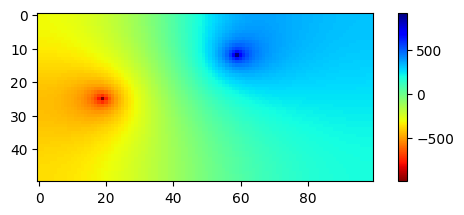

In [12]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.imshow(head, cmap='jet_r')
plt.colorbar()
plt.show()

In [13]:
engine.read_flow_drawdown(idx=0, layer=0)

[]

In [14]:
engine.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 365000.0,
 'TOTAL_IN': 365000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -365000.0,
 'TOTAL_OUT': -365000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 0.75149995}

In [15]:
engine.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 1000.0,
 'TOTAL_IN': 1000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -1000.0,
 'TOTAL_OUT': -1000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}